# Introduction to Clustergram

When we want to do some cluster analysis to identify groups in our data, we often use algorithms like K-Means, which require the specification of a number of clusters. But the issue is that we usually don't know how many clusters there are. 

There are many methods on how to determine the correct number, like silhouettes or elbow plot, to name a few. But they usually don't give much insight into what is happening between different options, so the numbers are a bit abstract.

[Matthias Schonlau](http://www.schonlau.net/clustergram.html) proposed another approach - a clustergram. Clustergram is a two-dimensional plot capturing the flows of observations between classes as you add more clusters. It tells you how your data reshuffles and how good your splits are. [Tal Galili](https://www.r-statistics.com/2010/06/clustergram-visualization-and-diagnostics-for-cluster-analysis-r-code/) later implemented clustergram for K-Means in R. And we have used Tal's implementation, ported it to Python and created `clustergram` - a Python package to make clustergrams.

`clustergram` currently supports K-Means and using `scikit-learn` (inlcuding Mini-Batch implementation) and RAPIDS.AI `cuML` (if you have a CUDA-enabled GPU), Gaussian Mixture Model (`scikit-learn` only) and hierarchical clustering based on `scipy.hierarchy`. Alternatively, we can create clustergram based on labels and data derived from alternative custom clustering algorithms. It provides a sklearn-like API and plots clustergram using matplotlib, which gives it a wide range of styling options to match your publication style.

In [1]:
from clustergram import Clustergram
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [2]:
sns.set(style='whitegrid')

Let us look at some examples to understand how clustergram looks and what to do with it.

## Iris flower data set

The first example which we try to analyse using clustergram is the famous Iris flower data set. It contains data on three species of Iris flowers measuring sepal width and length and petal width and length. We can start with some exploration:

/Users/martin/mambaforge/envs/clustegram_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


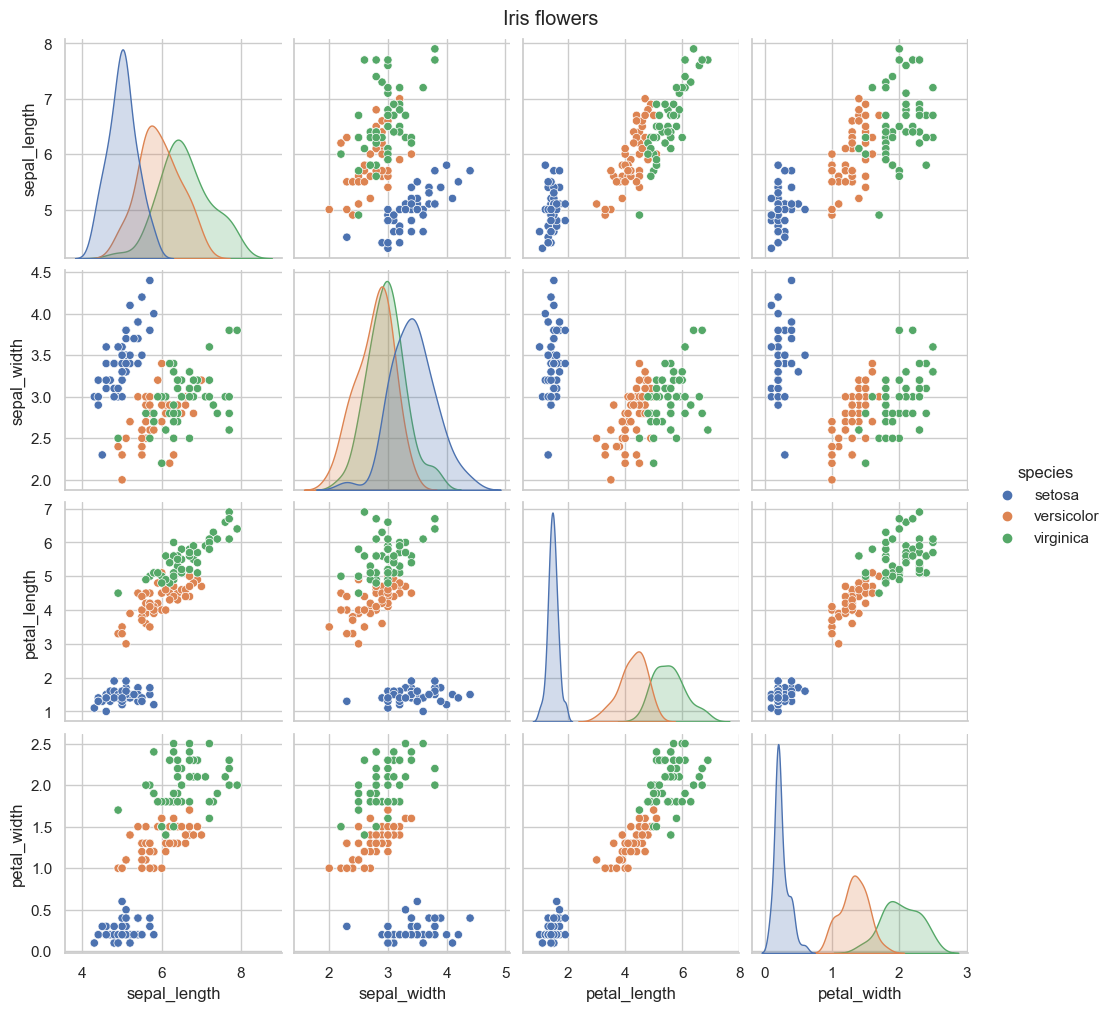

In [3]:
iris = sns.load_dataset("iris")
g = sns.pairplot(iris, hue="species")
g.fig.suptitle("Iris flowers", y=1.01);

It seems that _setosa_ is a relatively well-defined group, while the difference between _versicolor_ and _virginica_ is smaller as they partially overlap (or entirely in the case of sepal width). 

Okay, so we know how the data looks. Now we can check how does clustergram look. Remember that we know that there are three clusters, and we should ideally be able to recognise this from clustergram. I am saying ideally because even though there are known labels, it does not mean that our data or clustering method are able to distinguish between those classes.

Let's start with K-Means clustering. To get a stable result, we can run a clustergram with 100 initialisations. Feel free to run even more.

In [4]:
data = scale(iris.drop(columns=['species']))

In [5]:
cgram = Clustergram(range(1, 10), n_init=100, verbose=False)
cgram.fit(data)

Clustergram(k_range=range(1, 10), backend='sklearn', method='kmeans', kwargs={'n_init': 100})

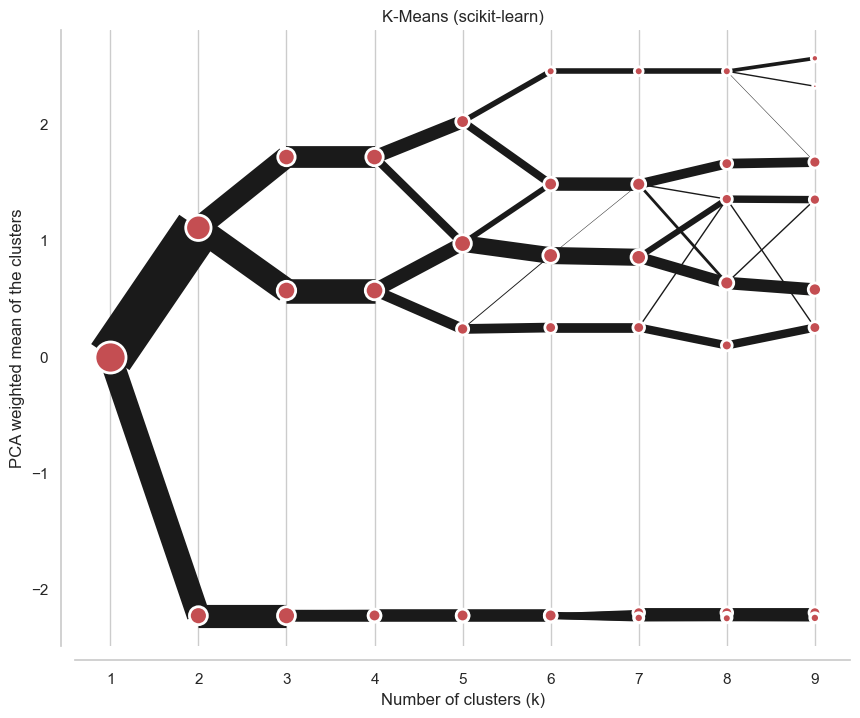

In [6]:
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)');

On the _x_ axis, we can see the number of clusters. Points represent a centre of each cluster (by default) weighted by the first principal component (that helps with the diagram's readability). The lines connecting points and their thickness represent observations moving between clusters. Therefore, we can read when new clusters are formed as a split of a single existing class and when they are formed based on observations from two clusters.

We're looking for the separation, i.e., did an additional cluster bring any meaningful split? The step from one cluster to two is a big one - nice and clear separation. From two to three, we also have quite a nice split in the top branch. But from 3 to 4, there is no visible difference because the new fourth cluster is almost the same as the existing bottom branch. Although it is now separated into two, this split does not give us much information. Therefore, we could conclude that the ideal number of clusters for Iris data is three.

We can also check some additional information, like a silhouette score or Calinski-Harabazs score.

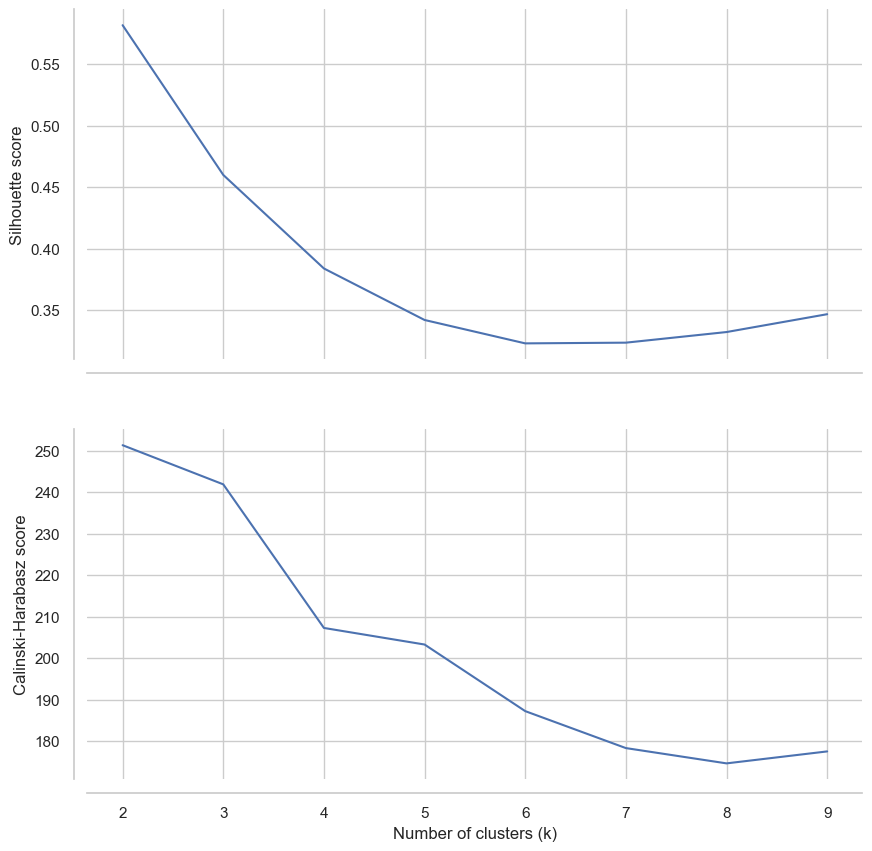

In [7]:
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(xlabel="Number of clusters (k)", ylabel="Silhouette score", ax=axs[0])
cgram.calinski_harabasz_score().plot(xlabel="Number of clusters (k)", ylabel="Calinski-Harabasz score", ax=axs[1])
sns.despine(offset=10)

These plots would suggest 3-4 clusters, similarly to clustergram, but they are not very conclusive.

## Palmer penguins data set

Now let's try different data, one where clusters are a bit more complicated to assess. Palmer penguins contain similar data as Iris example, but it measures several attributes of three species of penguins.

In [8]:
penguins = sns.load_dataset("penguins")

/Users/martin/mambaforge/envs/clustegram_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


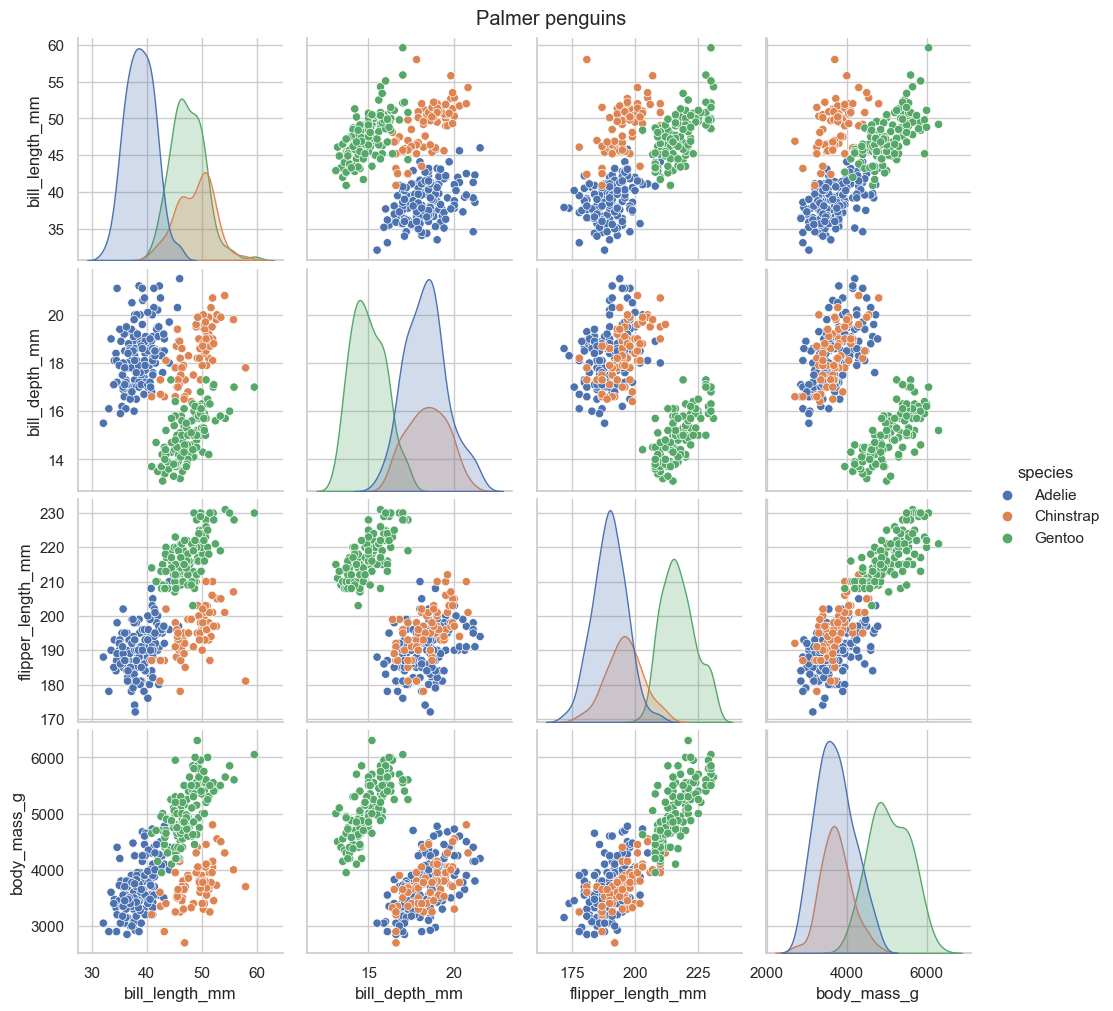

In [9]:
g = sns.pairplot(penguins, hue="species")
g.fig.suptitle("Palmer penguins", y=1.01);

Looking at the situation, we see that the overlap between species is much higher than before. It will likely be much more complicated to identify them. Again, we know that there are three _clusters_, but that does not mean that data has the power to distinguish between them. In this case, it may be especially tricky to differentiate between _Adelie_ and _Chinstrap_ penguins.

In [10]:
data = scale(penguins.drop(columns=['species', 'island', 'sex']).dropna())

In [11]:
cgram = Clustergram(range(1, 10), n_init=100, verbose=False)
cgram.fit(data)

Clustergram(k_range=range(1, 10), backend='sklearn', method='kmeans', kwargs={'n_init': 100})

Text(0.5, 1.0, 'K-Means (scikit-learn)')

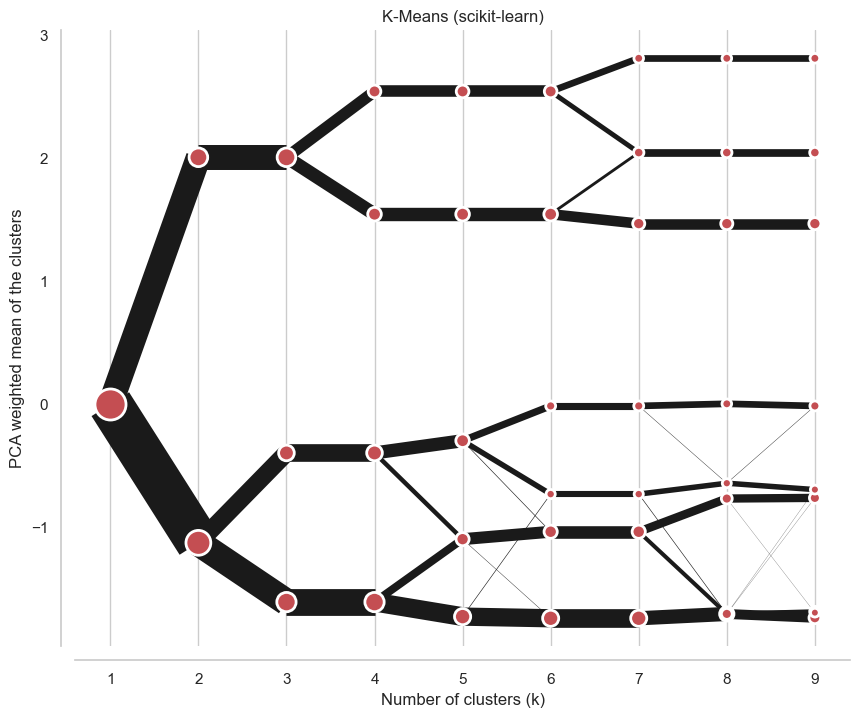

In [12]:
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

We're looking for separations, and this clustergram shows plenty. It is actually quite complicated to determine the optimal number of clusters. However, since we know what happens between different options, we can play with that. If we have a reason to be conservative, we can go with 4 clusters (I know, it is already more than the initial species). But further splits are also reasonable, which indicates that even higher granularity may provide useful insight, that there might be meaningful groups.

Can we say it is three? Since we know it should be three... Well, not really. The difference between the split from 2 - 3 and that from 3 - 4 is slight. However, the culprit here is K-Means, not clustergram. It just simply cannot correctly cluster these data due to the overlaps and the overall structure. 

Let's have a look at how the Gaussian Mixture Model does.

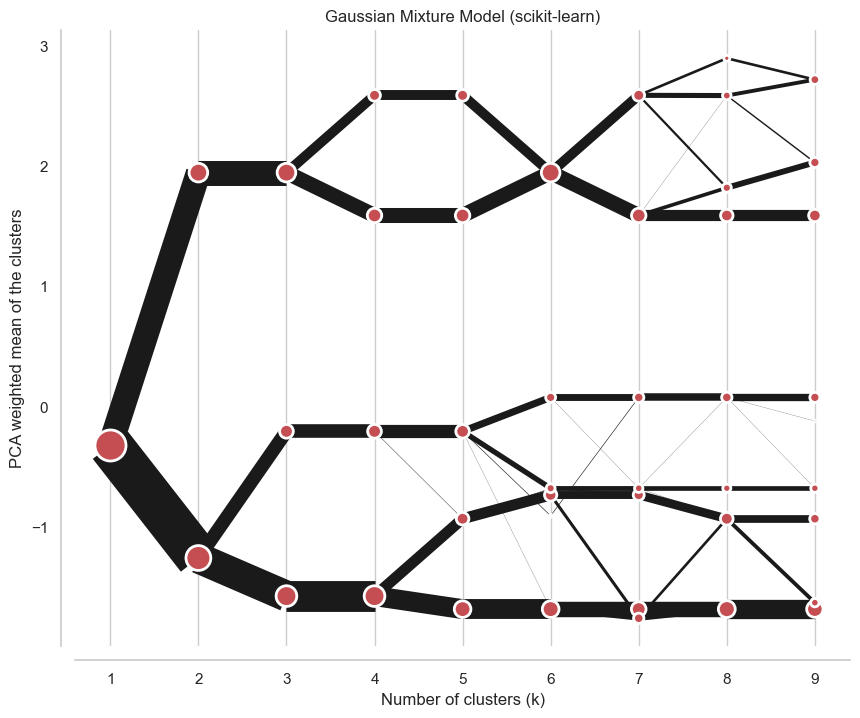

In [13]:
cgram = Clustergram(range(1, 10), n_init=100, method="gmm", verbose=False)
cgram.fit(data)
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('Gaussian Mixture Model (scikit-learn)');

The result is very similar, though the difference between the third and fourth split is more pronounced. Even here, I would probably go with a four cluster solution.

A situation like this happens very often. The ideal case does not exist. We ultimately need to make **a decision** on the optimal number of clusters. Clustergam gives us additional insights into what happens between different options, how it splits. We can tell that the four-cluster option in Iris data is not helpful. We can tell that Palmer penguins may be tricky to cluster using K-Means, that there is no decisive _right_ solution. Clustergram does not give an easy answer, but it gives us additional insight, and it is upon us how we interpret it.


If you want to play with the examples used in this documentation, the Jupyter notebook is on [GitHub](https://github.com/martinfleis/clustergram/blob/main/doc/). You can also run it in [an interactive binder environment](https://mybinder.org/v2/gh/martinfleis/clustergram/HEAD?filepath=doc) in your browser.

For more information, check [Tal Galili's blog post](https://www.r-statistics.com/2010/06/clustergram-visualization-and-diagnostics-for-cluster-analysis-r-code/) and [original papers by Matthias Schonlau](http://www.schonlau.net/clustergram.html).

Give it a go!